In [275]:
import numpy as np
import pandas as pd

In [276]:
dir(pd)

['Categorical',
 'CategoricalIndex',
 'DataFrame',
 'DateOffset',
 'DatetimeIndex',
 'ExcelFile',
 'ExcelWriter',
 'Expr',
 'Float64Index',
 'Grouper',
 'HDFStore',
 'Index',
 'IndexSlice',
 'Int64Index',
 'LooseVersion',
 'MultiIndex',
 'NaT',
 'Panel',
 'Panel4D',
 'Period',
 'PeriodIndex',
 'Series',
 'SparseArray',
 'SparseDataFrame',
 'SparseList',
 'SparsePanel',
 'SparseSeries',
 'SparseTimeSeries',
 'Term',
 'TimeGrouper',
 'TimeSeries',
 'Timedelta',
 'TimedeltaIndex',
 'Timestamp',
 'WidePanel',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__docformat__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '__warningregistry__',
 '_np_version',
 '_np_version_under1p8',
 '_np_version_under1p9',
 '_period',
 '_sparse',
 '_testing',
 '_version',
 'algos',
 'bdate_range',
 'compat',
 'computation',
 'concat',
 'core',
 'crosstab',
 'cut',
 'date_range',
 'datetime',
 'datetools',
 'describe_option',
 'eval',
 'ewma',
 'ewmcorr',
 '

### Чтение файла 

In [277]:
# менять данную константу, если нужно сменить имя файла
FILE = 'try.xlsx'

In [278]:
data = pd.read_excel(FILE, index_col=0)

In [279]:
val = data.values
np.isnan(val)
np.sum(~np.isnan(val))

44

## 1) Фильтр отсутствия данных

In [280]:
#Константа для порогового значения, больше этого значения анкеты убираем
THRESHOLD = 0.4

Формируем набор $\phi_i $

In [281]:
logic_data = data.isnull()
ssv = logic_data.sum().sum() #сумма по всем v_ij
sv = logic_data.sum() #сумма по столбцам
#print(sv)
q_j = ssv/sv
sq_j = q_j[q_j != np.inf].sum() # стобцы со всеми заполненными строками не участвуют
#print(sq_j)

q_j[q_j == np.inf] = sq_j #костыли, чтоб бесконечности не было
Q_j = q_j / sq_j
#print(Q_j)
pheta_table = Q_j * logic_data
pheta_i = pheta_table.sum(axis=1)
pheta_i_sorted = pheta_i.sort_values(ascending=False)
pheta_i_sorted[pheta_i_sorted>THRESHOLD]

Date
2015-12-20    0.588235
2015-12-21    0.411765
dtype: float64

In [282]:
sv

X1    2
X2    0
X3    5
X4    1
dtype: int64

Визуализируем

Populating the interactive namespace from numpy and matplotlib


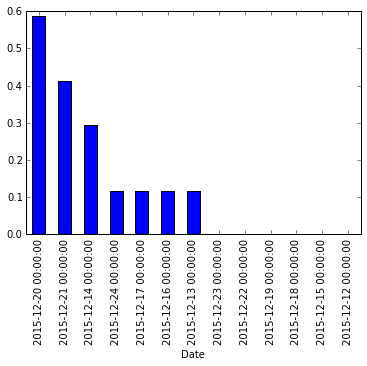

In [283]:
import matplotlib.pylab as pl
%pylab inline
pheta_i_sorted.plot(kind='bar')


In [284]:
dir(pheta_i)

['T',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_SLICEMAP',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_prepare__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__int__',
 '__invert__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',

##  2) Фильтр отсутствия данных групповой

Этот блок можно использовать для создания массива индексов групп пакетов

In [285]:
Nr = 5 # Количество анкет в пакете

In [286]:
ss_pheta_i = pheta_i.sum().sum()
Nr_counter = 0
N0 = len(data.index)
#делаем массив пакетов (начало, конец)
groups = []
one = []
####################################
# Делаем группы пакетов ############
def make_groups(Nr):
    groups = []
    one = []
    for row_n in range(N0):
        if (len(one) == Nr):
            groups.append(one)
            one = []
        one.append(data.index[row_n])
    else:
        if len(one)>0:
            groups.append(one) 
    return groups
####################################

Конец блока

In [287]:
Vr = []
groups = make_groups(Nr)
for group in groups:
    pheta_group = pheta_i[group]
    Wr = pheta_group.sum() / len(group)
    W_r = (ss_pheta_i -  pheta_group.sum()) / (N0 - len(group))
    Vr.append(W_r - Wr)

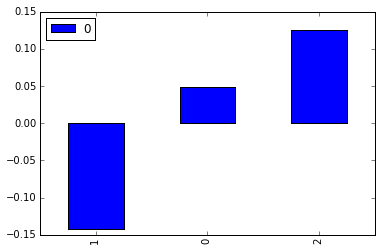

In [394]:
Vr_p = pd.DataFrame(Vr)
Vr_p = Vr_p.sort_values(by=0)
Vr_p.plot(kind='bar')

## 3) Фильтр экстремальных непрерывных значений

In [391]:
X_minus_r = []
X_r = []
groups = make_groups(Nr)
for group in groups:
    data_group = data.loc[group]
    X_r.append(data_group.mean())
    data_group_out = data.loc[(data.index < group[0]) | (data.index > group[-1])]
    X_minus_r.append(data_group_out.mean())
    
lambd = []
for i in range(len(X_r)):
    lambd.append(X_minus_r[i] - X_r[i])

max_lambd = np.max(np.transpose(np.dstack(lambd)), axis=0)

lambd_cols = np.array(lambd).transpose()

Mu = []

for i in range(len(lambd_cols)):
    max_i = float(max_lambd[i])
    Mu.append(lambd_cols[i] == max_i)
    
Mu_i = np.array(Mu).transpose()
Mu_i = Mu_i.sum(axis=1)

In [403]:
THRESHOLD = 2.

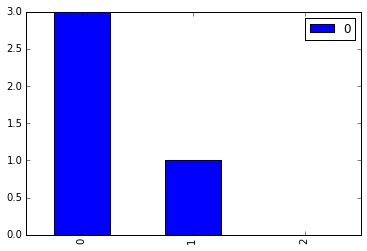

In [405]:
Mu_p = pd.DataFrame(Mu_i)
Mu_p = Mu_p.sort_values(by=0, ascending=False)
Mu_p.plot(kind='bar')
#Mu_p[Mu_p>THRESHOLD]

In [291]:
logic_data

,X1,X2,X3,X4
Date,,,,
2015-12-12,False,False,False,False
2015-12-13,False,False,True,False
2015-12-14,True,False,False,False
2015-12-15,False,False,False,False
2015-12-16,False,False,True,False
2015-12-17,False,False,True,False
2015-12-18,False,False,False,False
2015-12-19,False,False,False,False
2015-12-20,False,False,False,True
